# DevTool: Lattice2D
<hr><br>
Developers' tools iPython Notebook for the Lattice2D object

In [1]:
%matplotlib inline
#
from lrgsglib.core import *
#
move_to_rootf()
plt.style.use(os.path.join('ipynb', 'nb_plotsheet.mplstyle'))
#
datpath = os.path.join('ipynb', 'data')
datpath_clust_rew = os.path.join('data', 'cluster_data', 'rewired_2D')
#
kwargL3D = dict(dataOut=datpath)

Current working directory: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib


In [2]:
lattice = Lattice2D(128, pflip=0.1)
lattice.flip_random_fract_edges()
lattice.compute_k_eigvV()

(-0.5, 127.5, -0.5, 127.5)

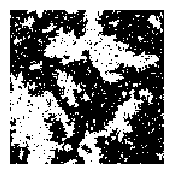

In [7]:
plt.figure(figsize=(2,2))
plt.imshow(lattice.get_eigV_bin_check(0).reshape(*lattice.syshape), interpolation='none', cmap='Greys')
plt.axis('off')

In [4]:
lattice.load_eigV_on_graph(which=0, binarize=True)
lattice.make_clustersYN(f"eigV0", -1)

In [116]:
p = 0.1
l = Lattice2D(96, pflip=p, geo='sqr', init_nw_dict=True)
l.flip_sel_edges(l.nwDict['randXERR']['G'])
fraction_of_neg_edges = l.Ne_n/l.Ne

In [117]:
count = 0
for i in l.G:
    is_antiferro_node = all([v['weight'] == -1 for k,v in l.G[i].items()])
    count += 1 if is_antiferro_node else 0 

fraction_antiferro_nodes = count/l.N
est_fraction_antiferro_nodes = p+p**4*(1-p)
print(fraction_antiferro_nodes, est_fraction_antiferro_nodes)

0.09993489583333333 0.10009000000000001


0 {96: {'weight': 1}, 1: {'weight': 1}, 9120: {'weight': -1}, 95: {'weight': 1}} 3
1 {0: {'weight': 1}, 97: {'weight': 1}, 2: {'weight': 1}, 9121: {'weight': 1}} 4
2 {1: {'weight': 1}, 98: {'weight': 1}, 3: {'weight': 1}, 9122: {'weight': -1}} 3
3 {2: {'weight': 1}, 99: {'weight': 1}, 4: {'weight': 1}, 9123: {'weight': 1}} 4
4 {3: {'weight': 1}, 100: {'weight': 1}, 5: {'weight': 1}, 9124: {'weight': 1}} 4
5 {4: {'weight': 1}, 101: {'weight': 1}, 6: {'weight': 1}, 9125: {'weight': 1}} 4
6 {5: {'weight': 1}, 102: {'weight': 1}, 7: {'weight': 1}, 9126: {'weight': 1}} 4
7 {6: {'weight': 1}, 103: {'weight': 1}, 8: {'weight': 1}, 9127: {'weight': 1}} 4
8 {7: {'weight': 1}, 104: {'weight': 1}, 9: {'weight': 1}, 9128: {'weight': -1}} 3
9 {8: {'weight': 1}, 105: {'weight': 1}, 10: {'weight': 1}, 9129: {'weight': 1}} 4
10 {9: {'weight': 1}, 106: {'weight': 1}, 11: {'weight': 1}, 9130: {'weight': 1}} 4
11 {10: {'weight': 1}, 107: {'weight': 1}, 12: {'weight': 1}, 9131: {'weight': 1}} 4
12 {11: {'

0.09993489583333333

In [4]:
l = Lattice2D(96, pflip=.2, geo='hex', init_nw_dict=True)
l.flip_sel_edges(l.nwDict['randXERR']['G'])
data = l.get_eigV_bin_check(which=0).reshape(l.syshape)

In [ ]:
from scipy.ndimage import laplace
# Compute the Laplacian of the 2D data
data = l.eigV[0].reshape(*l.syshape)
laplacian_data = laplace(data)
plt.imshow(laplacian_data, cmap='viridis')


### Hexagonal 2D Lattice Eigenstate plot

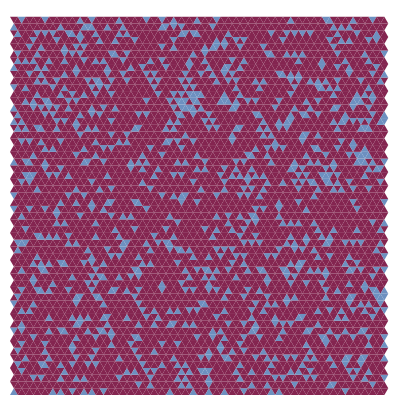

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_honeycomb_grid(data, fig, ax)

In [2]:
T = 0.5
pflip = 1
remove_files = False

In [3]:
l = Lattice2D(32, pflip=pflip, geo='tri')
l.flip_random_fract_edges()
l.compute_k_eigvV(MODE_dynspec='numpy')

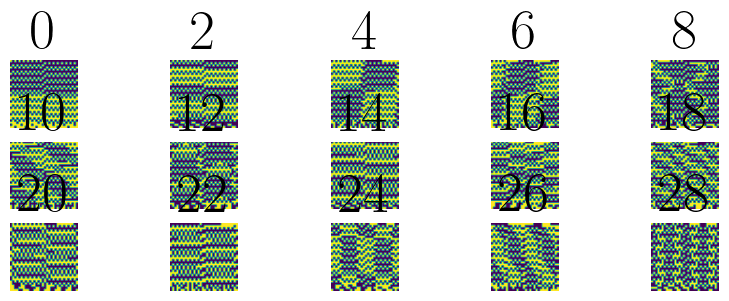

In [4]:
fig, ax = plt.subplots(3, 5, figsize=(10, 3.5))
count = 0
for i in range(3):
    for j in range(5):
        ax[i, j].imshow(l.get_eigV_bin_check(count).reshape(*l.syshape), origin='lower')
        ax[i, j].axis('off')
        ax[i, j].set_title(f'{count}')
        count += 2

In [5]:
isdy = IsingDynamics(l, T=T, ic='ground_state_0', runlang='C1', rndStr=True)
isdy.init_ising_dynamics()
l.export_edgel_bin(exName=isdy.id_string_isingdyn)
isdy.export_ising_clust()
isdy.run(verbose=False, thrmSTEP=100)
if remove_files:
    isdy.remove_run_c_files(remove_stderr=True)
    l.remove_edgl_file()

(-0.5, 31.5, -0.5, 31.5)

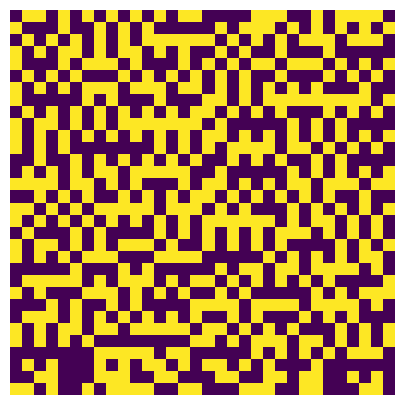

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(isdy.s.reshape(*l.syshape), origin='lower')
ax.axis('off')

In [7]:
isdy2 = IsingDynamics(l, T=0, ic='custom', runlang='C1', rndStr=True)
isdy2.init_ising_dynamics(custom=isdy.s)
l.export_edgel_bin(exName=isdy2.id_string_isingdyn)
isdy2.export_ising_clust()
isdy2.run(verbose=False, thrmSTEP=100)

(-0.5, 31.5, -0.5, 31.5)

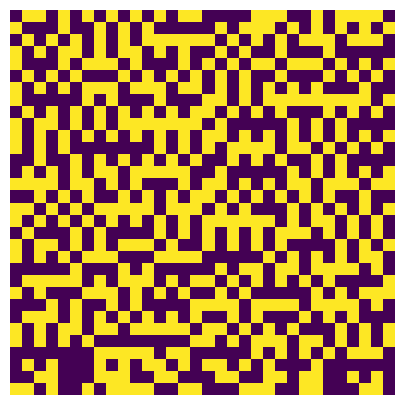

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(isdy2.s.reshape(*l.syshape), origin='lower')
ax.axis('off')

In [218]:
def spin_overlap(S1, S2):
     # Ensure both matrices have the same shape
     assert S1.shape == S2.shape, "Matrices must have the same shape!"

     # Direct overlap
     direct_overlap = np.sum(S1 * S2) / S1.size

     # Flipped overlap (inverted spins)
     flipped_overlap = np.sum(S1 * (-S2)) / S1.size

     # Return the maximum overlap, accounting for possible inversion
     return max(direct_overlap, flipped_overlap)

def matrix_projection(M, basis):
     projections = []

     # Iterate over each basis matrix
     for B_i in basis:
         # Compute the inner product between M and B_i
         inner_product = np.sum(M * B_i)

         # Compute the Frobenius norm of the basis matrix B_i
         norm_Bi = np.linalg.norm(B_i)

         # Compute the projection (normalized inner product)
         projection_i = inner_product / norm_Bi

         # Append the projection to the result list
         projections.append(projection_i)

     return projections
def reconstruct_from_projections(projections, basis):
     # Initialize the reconstructed matrix as zero
     reconstructed_matrix = np.zeros_like(basis[0])

     # Multiply each projection by its corresponding basis matrix and sum
     for i, B_i in enumerate(basis):
         reconstructed_matrix += projections[i] * B_i

     return reconstructed_matrix
def elements_within_eta_numpy(array, eta):
    """
    Returns elements in the array that are within eta from the minimum value.
    
    Parameters:
    - array (array-like): Input array of numerical values.
    - eta (float): Threshold value.
    
    Returns:
    - filtered_elements (np.ndarray): Elements within eta from the minimum.
    """
    array = np.array(array)  # Ensure input is a NumPy array
    min_val = np.min(array)
    displacement = array - min_val
    mask = displacement <= eta
    filtered_elements = array[mask]
    return filtered_elements

In [209]:
overlap = np.array([spin_overlap(isdy.s.reshape(*l.syshape),l.get_eigV_bin_check(i).reshape(*l.syshape)) for i in range(l.N)])
sorted_args = np.argsort(overlap)[::-1]
matproj = isdy.s.reshape(*l.syshape)
basis = np.array([l.eigV[i].reshape(*l.syshape) for i in sorted_args[:500]])
projections = np.array(matrix_projection(matproj, basis))

In [ ]:
overlap[sorted_args[:3]]

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
for i in range(3):
    ax[i].imshow(-l.get_eigV_bin_check(sorted_args[i]).reshape(*l.syshape), origin='lower')
    ax[i].axis('off')
    ax[i].set_title(f'{sorted_args[i]}')
ax[3].imshow(isdy.s.reshape(*l.syshape), origin='lower')
ax[3].axis('off')
ax[4].imshow(np.sign(reconstruct_from_projections(projections, basis)), origin='lower')
ax[4].axis('off')

In [ ]:
spin_overlap(isdy.s.reshape(*l.syshape), np.sign(reconstruct_from_projections(projections, basis)))

In [12]:
test_ene = [l.get_rbim_energy_eigV(_) for _ in range(l.N)]

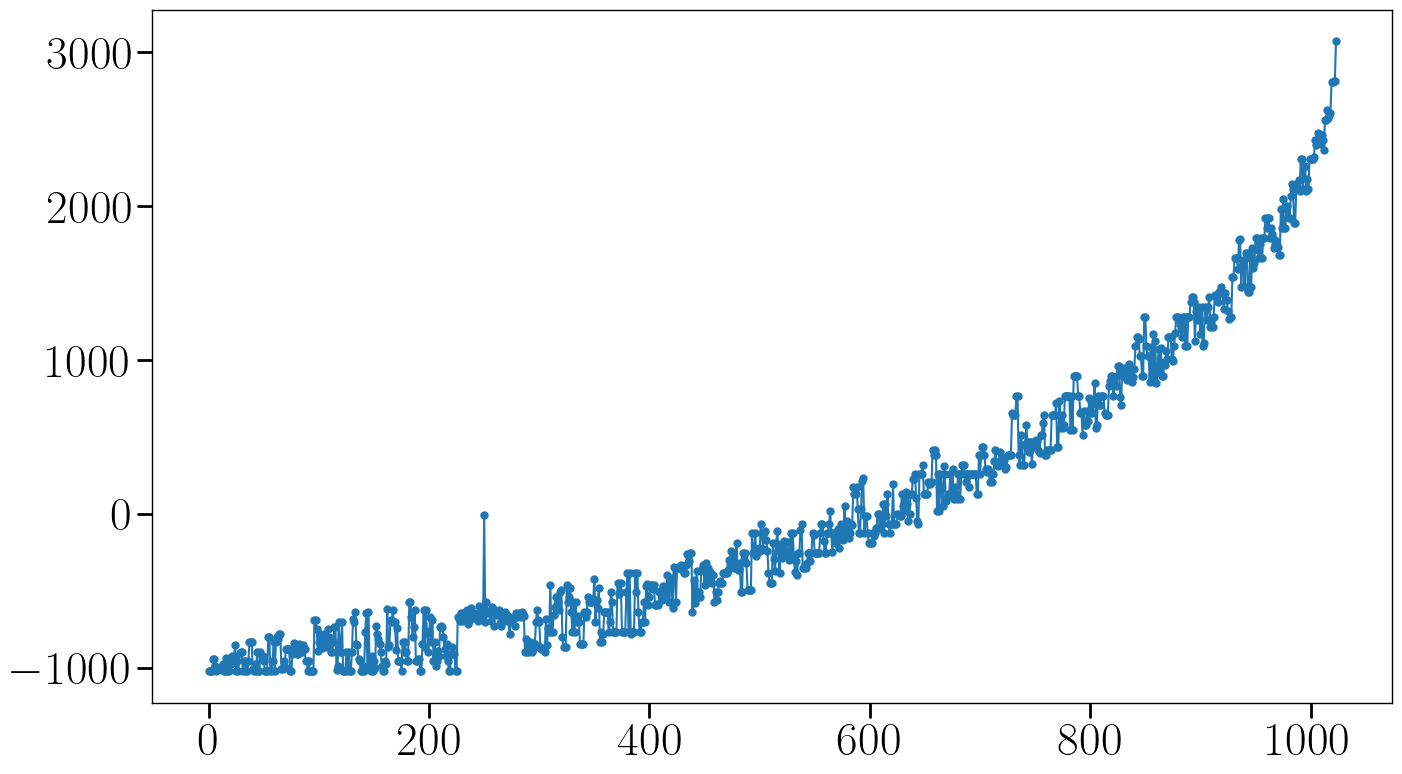

In [13]:
plt.plot(test_ene)

In [14]:
ls = Lattice2D(32, pflip=pflip, geo='sqr')
ls.flip_random_fract_edges()
ls.compute_k_eigvV(MODE_dynspec='numpy')

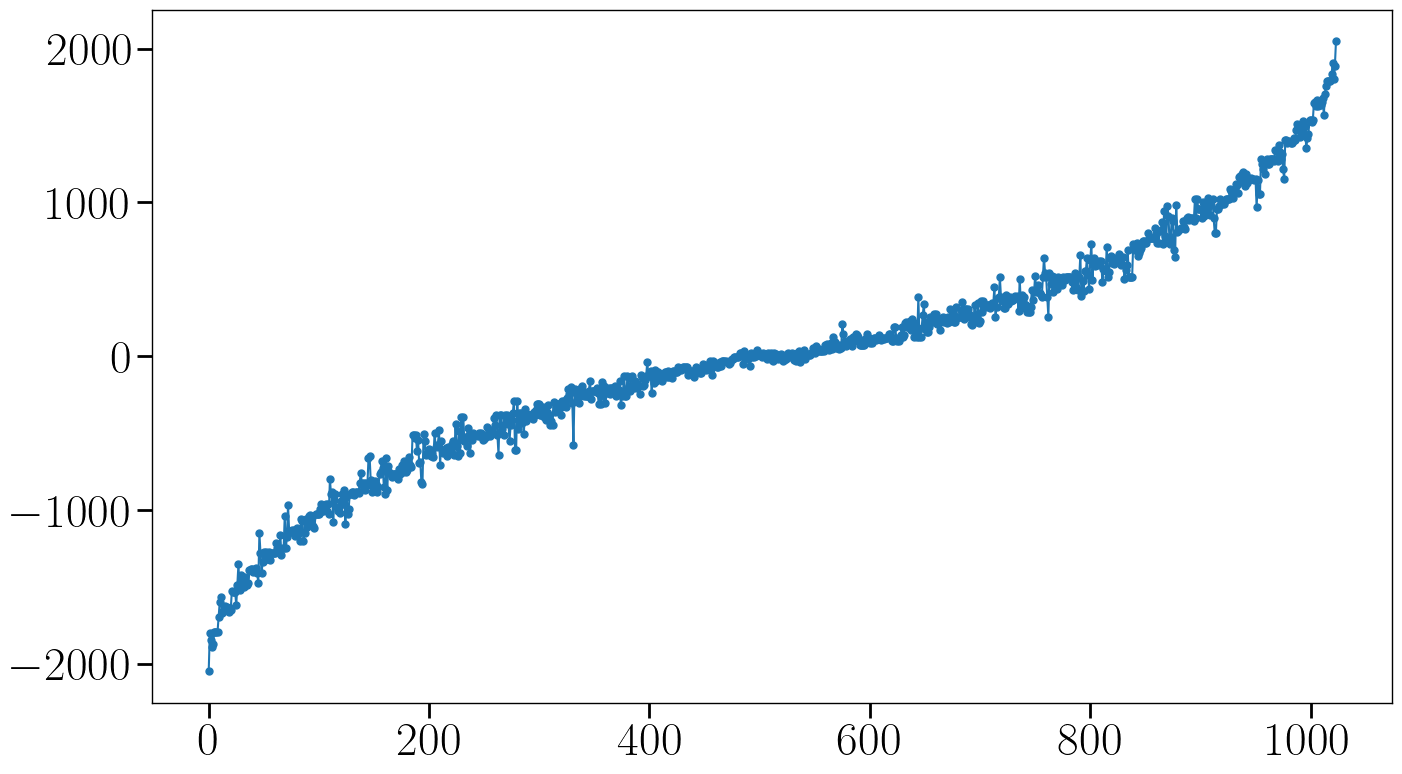

In [15]:
test_enes = [ls.get_rbim_energy_eigV(_) for _ in range(ls.N)]
plt.plot(test_enes)

In [43]:
ls = Lattice2D(32, pflip=0.01, prew=0.5, geo='sqr')
ls.flip_random_fract_edges()
ls.compute_k_eigvV(MODE_dynspec='numpy')

In [44]:
test_enes = [ls.get_rbim_energy_eigV(_) for _ in range(ls.N)]


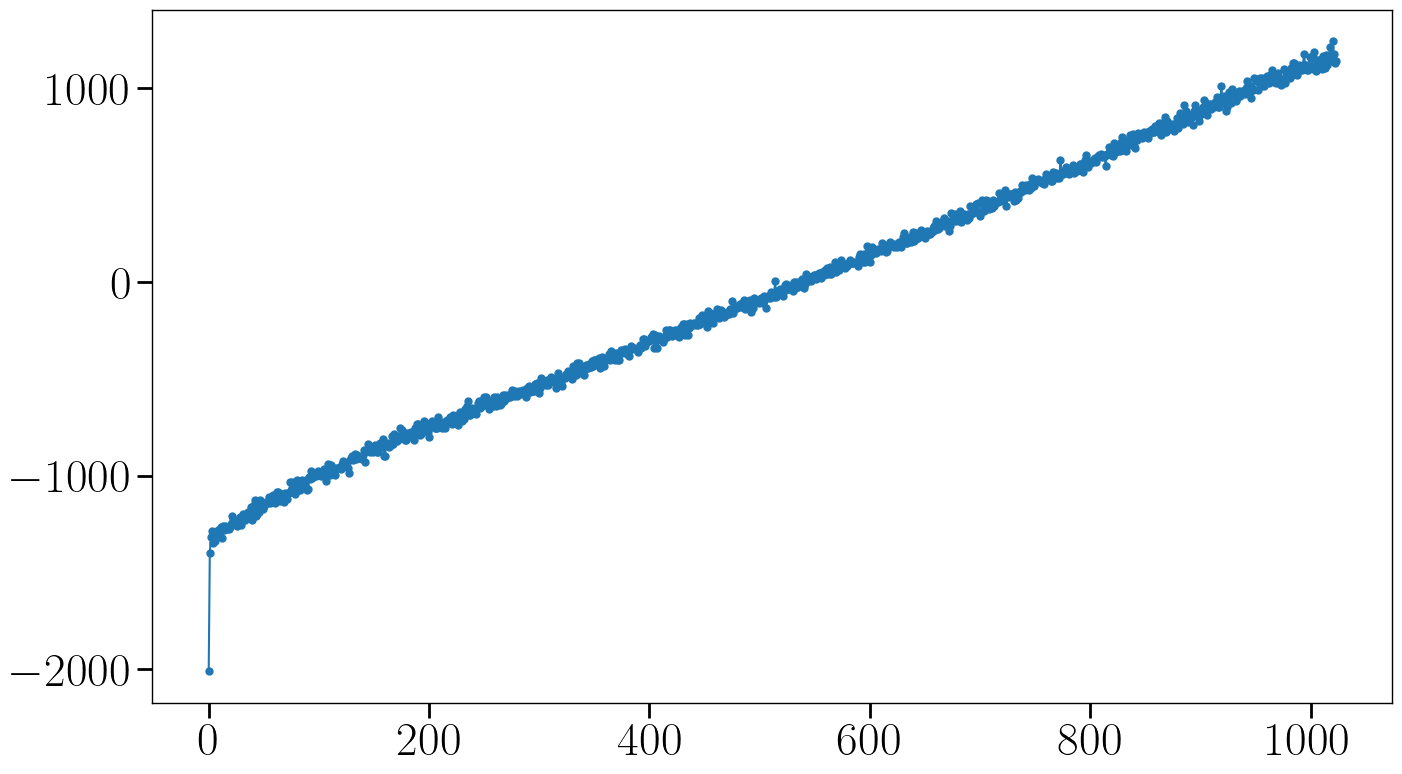

In [45]:
plt.plot(test_enes)

## Phase transition

### Rewired small world network (data from cluster)

In [6]:
LList = [32, 64, 96]
prew = 0.05
na = 10000
pL = np.linspace(0, 0.3, 100)
dat = {}

In [7]:
for L in LList:
    dat[L] = []
    l2 = Lattice2D(L, prew=prew, dataOut=datpath_clust_rew)
    for p in pL:
        dat[L].append(np.loadtxt(
            os.path.join(l2.phtrapath, 'ordParam'+\
                         '_'.join(["", f"p={p:.3g}", "rand", f"na={na}", 
                                   f"prew={prew:.3g}.txt"]))))

In [ ]:
for L in LList:
    plt.plot(pL, np.array(dat[L])[:, 4], label=f"{L*L}")
plt.xlabel(r'$p$')
plt.legend(loc='lower left', fontsize=30)
plt.title(r"Lattice 2D -- $p_{\rm rew} = 0.05$")
inset_axes(plt.gca(), width="40%", height="40%")
for L in LList:
    plt.plot(pL, np.array(dat[L])[:, 5]*L)

## Basic Visualization

### Small world Lattice 2D

In [ ]:
side = 16
prew = 0.05
pflip = 0.1
#
l_sw = Lattice2D(side, prew=prew, with_positions=True)
nx.draw(l_sw.G, pos=l_sw.get_node_attributes(), node_size=10)

# Trash

In [2]:
pflip = 0.25
side1 = 32

In [3]:
l = Lattice2D(side1, pflip=pflip)
l.flip_sel_edges(l.fleset['G'])
l.compute_k_eigvV(MODE_dynspec="numpy")

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

arr = l.eigV[0].reshape(*l.syshape)
compound_log_array = np.where(arr > 0, -np.log(arr), 
                              np.where(arr < 0, np.log(-arr), arr))

im = ax1.imshow(arr)
ax1.set_title(r"$|\lambda_0\rangle$")
plt.colorbar(im, ax=ax1)
im = ax2.imshow(compound_log_array)
ax2.set_title(r"$-\log(|\lambda_0^+\rangle)+\log(-|\lambda_0^-\rangle)$")
plt.colorbar(im, ax=ax2)
im = ax3.imshow(l.bin_eigV().reshape(*l.syshape))
ax3.set_title(r"$\mathrm{sign}(|\lambda_0\rangle)$")
plt.colorbar(im, ax=ax3)
plt.suptitle(f"Eigenvector 0 - p={pflip}")

In [ ]:
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(l.eigv[:100])))
ff = [l.compute_rbim_energy_eigV(_) for _ in range(100)]

In [ ]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# Plot each horizontal line with a different color
for value, value2, color in zip(l.eigv[:100], ff, colors):
    ax1.axhline(value, color=color)
    ax2.axhline(value2, color=color)
ax1.set_yscale('log')
plt.show()

In [ ]:
eigvlist = []
for i in range(100):
    l = Lattice2D(side1, pflip=0.5, seed=i)
    l.flip_sel_edges(l.fleset['G'])
    l.compute_k_eigvV()
    eigV = l.bin_eigV().reshape(*l.syshape)
    eigvlist.append(eigV)

In [ ]:
plt.imshow(eigvlist[40])

In [ ]:
from itertools import combinations
def calculate_overlap(arr1, arr2):
    return np.sum(arr1 == arr2)
overlaps = []
for (arr1, arr2) in combinations(eigvlist, 2):
    overlaps.append(calculate_overlap(arr1, arr2))

In [ ]:
plt.hist(overlaps, bins=30, edgecolor='black')

In [ ]:
test = pk.load(open('data/l2d_squared/lrgsg/N=4096/pCluster_p=0.103_randZERR_na=500_test01.pkl', 'rb'))

In [ ]:
k,v  = unzip_dict_items(test)
arr = np.repeat(k, v)
x, pdf = powerlaw.pdf(arr, xmin=1)

In [ ]:
# plot
fig, ax = plt.subplots(figsize=(7, 3.5))
#
ax.loglog(x[1:], pdf, 'o')
ax.loglog(x[1:], x[1:]**(-2.05))
#
ax.set_xlabel(r"$S$")
ax.set_ylabel(r"$P(S)$")
#
fig.tight_layout()

In [ ]:
l = Lattice2D(32, geo='hexagonal', with_positions=True, pbc=False)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_aspect('equal')
nx.draw(l.G, ax=ax, pos=l.get_node_pos(), node_size=10, with_labels=False)

In [ ]:
def eigV_for_lattice(side, **kwargs):
    l = Lattice2D(side, **kwargs)
    l.flip_random_fract_edges()
    l.compute_k_eigvV(MODE_dynspec='scipy')
    return flip_to_positive_majority(l.eigV[0])
def create_symmetric_log_bins(min_val, max_val, num_bins, incMagn = 4):
    """Creates symmetric logarithmic bins."""
    bins_positive = np.logspace(np.log10(min_val)-incMagn, np.log10(max_val)+incMagn, num_bins//2)
    bins_negative = -np.flip(bins_positive)
    return np.concatenate((bins_negative, [0], bins_positive))

def bin_eigenvalues(eig_values, bins):
    """Bins eigenvalues and counts occurrences in each bin."""
    indices = np.digitize(eig_values, bins, right=True)
    return Counter(indices)

In [ ]:
# Get initial eigenvalues to define bins
initial_eig = eigV_for_lattice(side, pflip=pflip, geo=geo)
bins = create_symmetric_log_bins(np.min(np.abs(initial_eig)), np.max(np.abs(initial_eig)), bins_count)
bin_counter = Counter()

if not os.path.exists(fname):
    nAvgDone = 0
    fnameExists = glob.glob(f"{workDir}{fnameBase}*")
    if fnameExists:
        nAvgDone = int(os.path.splitext(fnameExists[0].split('_')[-1])[0])
    nAvgNeed = nAvg - nAvgDone
    fnameOld = fnameExists[0]
    for current_period in range((nAvgNeed // period) + bool(nAvgNeed % period)):
        batch_size = min(nAvgNeed - current_period * period, period)
        eig_values = np.concatenate([eigV_for_lattice(side, pflip=pflip, geo=geo) for _ in range(batch_size)])
        bin_counter.update(bin_eigenvalues(eig_values, bins))
        fnameNew = f"{workDir}{fnameBase}_{nAvgDone + (current_period + 1) * period}.pkl"
        try:
            os.rename(fnameOld, fnameNew)
        except FileNotFoundError:
            pass
        with open(fnameNew, "wb") as f:
            pk.dump(dict(bin_counter), f)
        fnameOld = f"{workDir}{fnameBase}_{nAvgDone + current_period * period}.pkl" if current_period > 0 else ""

    # At the end, save the final state if needed
    if nAvgNeed % period:
        fnameNew = f"{workDir}{fnameBase}_{nAvg}.pkl"
        with open(fnameNew, "wb") as f:
            pk.dump(dict(bin_counter), f)


In [ ]:
k,v = zip(*pk.load(open(f"{workDir}{fnameBase}_{nAvg}.pkl", "rb")).items())
binsv = bins[np.array(k)-1]
zero_index = np.where(binsv > 0)[0][0]
negative_values = v[:zero_index]
positive_values = v[zero_index:]
plt.plot(binsv, v, 'o')
# plt.axhline(np.max(positive_values))
# plt.axhline(np.max(negative_values))

plt.xscale('symlog', linthresh=1e-17)
plt.yscale('log')


In [ ]:
negative_values, zero_index, np.where(binsv < 0), binsv

In [ ]:
l = Lattice2D(128, pflip=0.01)
l.flip_random_fract_edges()
l.compute_k_eigvV()
outp, outm = symlog_binning(flip_to_positive_majority(l.eigV[0]))

In [ ]:
plt.plot(outp[0], outp[1], 'o-')
plt.plot(outm[0], outm[1], 'o-')

In [ ]:
nAvg = 1000
pflip = 0.05
side = 16
geo = 'squared'

period = 20
freq = period**(-1)
workDir = "test/"
fnameBase = "tmp"
fname = f"{workDir}{fnameBase}_{nAvg}.pkl"

if not os.path.exists(fname):
    nAvgDone = 0
    flist = os.listdir(workDir)
    fnameExists = glob.glob(f"{workDir}{fnameBase}*")
    if len(fnameExists) > 1:
        print(f"Multiple files found for {fnameBase}")
        print(fnameExists)
        exit()
    else:
        if fnameExists:
            nAvgDone = int(os.path.splitext(fnameExists[0].split('_')[-1])[0])
            print(nAvgDone)
    nAvgNeed = nAvg - nAvgDone
    #
    lEigV = []
    print(fnameExists)
    fnameOld = fnameExists[0] if nAvgDone else ""
    if nAvgNeed < period:
        lEigV = [eigV_for_lattice(side, pflip=pflip, geo=geo) 
                 for i in range(nAvgNeed)]
        fnameNew = f"{workDir}{fnameBase}_{nAvg}.pkl"
        os.rename(fnameOld, fnameNew)
        with open(fname, "ab") as f:
            pk.dump(lEigV, f)
    else:
        for _ in range(period):
            lEigV = [eigV_for_lattice(side, pflip=pflip, geo=geo) 
                    for i in range(nAvgNeed//period)]
            fnameNew = f"{workDir}{fnameBase}_{nAvgDone+(_+1)*nAvgNeed//period}.pkl"
            try:
                os.rename(fnameOld, fnameNew)
            except FileNotFoundError:
                pass
            with open(fnameNew, "ab") as f:
                pk.dump(lEigV, f)
            fnameOld = f"{workDir}{fnameBase}_{nAvgDone+(_+1)*nAvgNeed//period}.pkl"
        if nAvgNeed%period:
            lEigV = [eigV_for_lattice(side, pflip=pflip, geo=geo) 
                    for i in range(nAvgNeed%period)]
            fnameNew = f"{workDir}{fnameBase}_{nAvg}.pkl"
            with open(fnameNew, "ab") as f:
                pk.dump(lEigV, f)

# for i in range(nAvg):
#     l = Lattice2D(side, pflip=pflip)
#     l.flip_random_fract_edges()
#     l.compute_k_eigvV()
#     lEigV.append(l.eigV[0])
#     with open(fname, "ab") as f:
#         pk.dump(, f)
#         f.flush()

In [ ]:
all_data = []
with open(fname, "rb") as f:
    # Loop until the end of the file
    while True:
        try:
            # Unpickle the next chunk of data and append it to the list
            data_chunk = pk.load(f)
            all_data.extend(data_chunk)
        except EOFError:
            # Reached the end of the file
            break

In [ ]:
all_data

In [ ]:
data.shape

In [ ]:
l = Lattice2D(side1=16,
              pflip=0.25,  
              pbc=False, 
              geo='hexagonal', 
              init_nw_dict=True, 
              with_positions=True)
l.flip_sel_edges(l.nwDict['randZERR']['G'])


In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
nx.draw(l.G, ax=ax, pos=nx.get_node_attributes(l.G, 'pos'), 
        node_size=40, 
        node_color=['red' if i in l.nwDict.rNodeFlip['G'] else 'blue' for i in l.G.nodes()],
        edgecolors='k', linewidths=1, width=2, 
        edge_color=['r' if w < 0 else 'blue' 
                    for u, v, w in list(l.G.edges(data='weight'))],
        # with_labels=True
        )